In [99]:
import pandas as pd
import numpy as np
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from datetime import datetime

warnings.filterwarnings("ignore")
sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report

In [9]:
modelos = [
    {
        "nombre": "Naive Bayes",
        "modelo": MultinomialNB(),
        "param_grid": {
            "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
            "fit_prior": [True, False],
        },
    },
    {
        "nombre": "Arbol Clasificacion",
        "modelo": DecisionTreeClassifier(),
        "param_grid": {
            "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
            "max_leaf_nodes": [1, 2, 3, 4, 5],
            "criterion": ["gini", "entropy"],
        },
    },
    {
        "nombre": "Random Forest",
        "modelo": RandomForestClassifier(),
        "param_grid": {
            "max_depth": [5, 6, 7, 8, 9, 10],
            "n_estimators": [500, 600, 700, 800, 900, 1000],
            "max_features": ["sqrt", "log2"],
        },
    },
    {
        "nombre": "Gradient Bossting",
        "modelo": GradientBoostingClassifier(),
        "param_grid": {
            "max_depth": [5, 6, 7, 8, 9, 10],
            "learning_rate": [0.001, 0.01, 0.1, 1],
        },
    },
    {
        "nombre": "SVM",
        "modelo": SVC(),
        "param_grid": {"C": [0.1, 1, 10, 100], "kernel": ["linear", "poly"], "degree": [2, 3, 4]},
    },
]

In [10]:
def entrenar_ensamble_de_modelos_gridcv(
    grilla_gridcv_con_modelos, X_train, X_test, y_train, y_test, funcion_metrica
):
    for model_info in grilla_gridcv_con_modelos:
        print("Training", model_info["nombre"], "...")
        model = model_info["modelo"]
        param_grid = model_info["param_grid"]

        grid_search = GridSearchCV(model, param_grid, cv=5)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        y_pred = best_model.predict(X_test)
        accuracy = funcion_metrica(y_test, y_pred)

        print("Best parameters:", best_params)
        print("Accuracy:", accuracy)
        print("---")

In [11]:
df = pd.read_csv("RegistroTumores_FALP.csv")

In [120]:
# Deja solo el cancer de mama
mama = df.query("CATEGORIA == 'MAMA'")
mama = mama.drop(columns=["CATEGORIA", "SUBCATEGORIA", "CODIGO_COMUNA"])
# Elimina los que carezcan de un estadio
mama = mama[~mama["ESTADIO"].isna()]
# Binariza la edad
mama["RANGO_ETARIO"] = pd.cut(
    mama["EDAD"],
    [-np.inf, 5, 11, 18, 26, 60, np.inf],
    labels=["Primera Infancia", "Infancia", "Adolescencia", "Juventud", "Adultez", "Vejez"],
)

# Rellena los datos patologicos con SO
columnas_a_rellenar_nan = ["CT", "CN", "CM", "PT", "PN", "PM"]
mama[columnas_a_rellenar_nan] = mama[columnas_a_rellenar_nan].fillna("SO")

# Castea las fechas
columnas_fechas = ["FECHA_DIAGNOSTICO", "FECHA_DEFUNCION", "FECHA_INICIO_TTO", "FECHA_FIN_TTO"]
# for fecha in columnas_fechas:
#     mama[fecha] = pd.to_datetime(mama[fecha], yearfirst=True)
#     pd.to_datetime(mama[fecha], yearfirst=True)

# dia_corte = pd.Timestamp(year=2023, month=6, day=8)

# mama["DURACION_TRATAMIENTO"] = mama["FECHA_FIN_TTO"] - mama["FECHA_INICIO_TTO"]
# mama["ESPERA_TRATAMIENTO"] = mama["FECHA_INICIO_TTO"] - mama["FECHA_DIAGNOSTICO"]

mama = mama.drop(columns=columnas_fechas)

# Crea el vector objetivo
reemplazar_estadio = {
    "0": 1,
    "I": 1,
    "II": 2,
    "III": 3,
    "IV": 3,
}

mama["STATUS"] = mama["ESTADIO"].replace(reemplazar_estadio)
mama = mama.drop(columns=["ESTADIO"])
mama = mama.fillna("SO")

<Axes: >

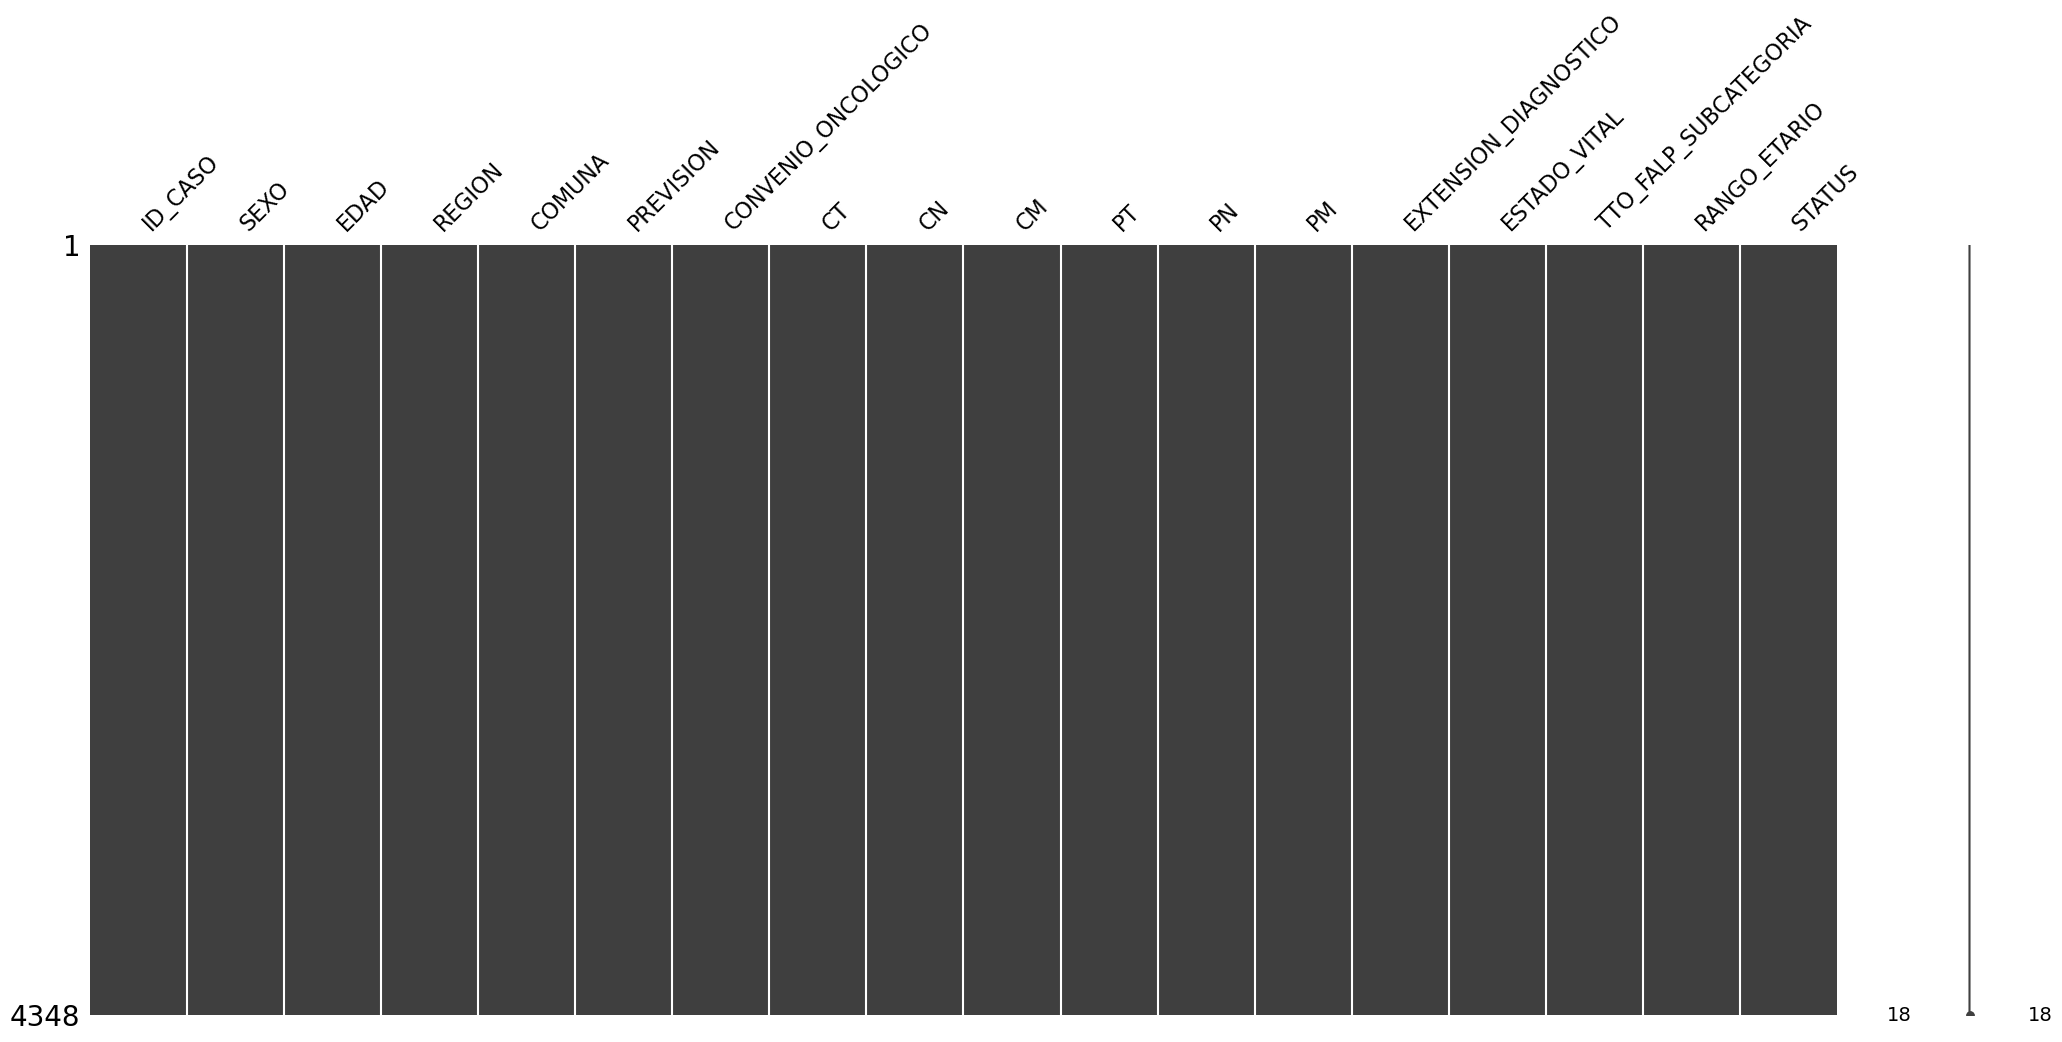

In [121]:
msno.matrix(mama)